# _A Mitigation-Reassignment Protocol :_

## _Experimental Demonstration of a Quantum Four-Sided Dice Model and of Preserved  Coherence in a Four-Qubit Entangled State_


## Introduction:



In this tutorial you will implement a quantum computing mitigation-reassignment protocol (QCMR). As an option, reassignment alone will also be tested.

This protocol will be tested experimentally on a quantum four-sided dice model.

The dice model will then be used, after inserting in the circuit a time delay, for assessing the evolution of the coherence of a multiple-qubit entangled state under QCMR.

### The QCMR protocol:

The complete protocol is as follows: 

- A mitigation filter is obtained for n physical qubits of a chosen quantum device (see [this tutorial](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/ignis/4_measurement_error_mitigation.ipynb))
- An entangled state of these n qubits $ \mid Q \rangle$ is created, with corresponding ideal measurement result distribution $Q_{ideal}$
- The legal set of results is defined as the set of results with non-zero probablility in $Q_{ideal}$. 
- A training set of raw results is obtained, with probability distribution $P_{raw}$
- The mitigation filter is applied on the raw results. Mitigated results with distribution $P_{mit}$ are obtained  
- The illegal set of results in $P_{mit}$ is defined as the set of results absent from the legal set. 
- Reassignment of the mitigated results is made, consisting of surjection (mapping) of the illegal set onto the legal set and obtention of the probablility distribution after reassignment $P_{obs}$.
- The best mapping combination is obtained by minimizing a metric measuring the distance separating $P_{obs}$ from $Q_{ideal}$

### Making a quantum model of four-sided dice using QCMR:

The common form for a four-sided dice used by old school statisticians is a tetrahedron. When you look at the dice, each visible side shows the same triplet of digits and the outcome is the missing digit. 

<img src="4-sided_dice_250.jpg" width="125" />
$$ \ Outcome \ is \ 3 $$

*(figure from Wikipedia, [licence](https://commons.wikimedia.org/wiki/File:4-sided_dice_250.jpg))*

When thrown, each side has a ¼ probability to end downward. Another particularity is that such a dice ending in equilibrium on an apex or an edge is nearly impossible.

A sequence of unbiased dice rolls can be described by a multinomial statistical distribution, consisting of a discrete random variable having four possible outcomes, each with probabilities concentrated around ¼ for $k$ successive trials.

The quantum state corresponding to an unbiased four-sided dice is a maximally entangled four-qubit W-state:

$$ \mid Q \rangle = \frac{ \mid{0001} \rangle + \mid{0010} \rangle + \mid{0100} \rangle + \mid{1000} \rangle }{2}$$

The corresponding legal set of results in  $Q_{ideal}$ is ('0001', '0010', '0100',  '1000') with probability ¼ for each result.

If you want to reproduce such a dice equivalent on a real noisy quantum device, two major issues appear.

First, the probabilities of each legal result will differ from the ideal case, hence the need for mitigation.

Secondly, the elements of the illegal set of results are the equivalent of the dice ending frequently on an edge or an apex. Reassignment will provide a table (in form of a python dictionary) mapping the results of single measurements onto the four outcomes of the throw of the dice.

You will use this table for testing (and using if you wish) the quantum four-sided dice that you just made.

### Preservation of the quantum state

One interesting property emerging from QCMR is longer preservation of the coherence of $\mid Q \rangle$. Multi-qubit decoherence can be studied in a superconducting processor by introducing a delay time between state creation and measurement ([Ozaeta & McMahon](https://arxiv.org/abs/1712.07080v2)).

A W-state, as used in the present model, is better balanced for QCMR than a GHZ state, where propensity to decay towards the ground state will rapidly skew $P_{raw}$ in disadvantage of the '1111' result.

In the last part of this tutorial, you will explore coherence preservation by inserting in your circuit an increasing number of identity gates between the quantum state creation and the measurement.

### Some remarks before starting

You may wonder why a four-qubit state is chosen here for making the four-sided dice. After all, the dice can be more simply simulated by using a two-qubit random number generator, which is equivalent to tossing twice a coin or tossing two coins simultaneously. However, this kind of approach would neither benefit of efficient reassignment nor allow to highlight coherence preservation.

A three-sided dice construction by QCMR is possible, but experience shows that the protocol effectiveness is hampered by the fact that the illegal result set is reduced to 5 elements.

Exploring "quantum dices" with more than four sides are exciting possibilities. However, the circuit depth increases significantly. In addition, for a $n\geq5$ qubit W-state, the determination of the optimal reassignment demands exploring a space of $n^{(2^{n}-\ n)}$ combinations with replacement, which is beyond the scope of this tutorial. This NP-hard problem of combinatorial optimization has similarities with the multidimensional knapsack problem. The finding of a workable non optimal combination by an approximation algorithm can be considered drawing on [this](https://en.wikipedia.org/wiki/Knapsack_problem). Confidently QCMR could be demonstrated for a 5-qubit state in an environment with more computer power and more performing programmation  than a simple laptop programmed in python alone.

Meanwhile, the four-side dice model appears optimal for a QCMR demonstration and well adapted to the real devices at disposal in the IBM Q experience.

In [1]:
import numpy as np
import time
import itertools
from operator import itemgetter
import copy
import pprint
import operator

from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute, transpile, assemble
from qiskit.providers.aer import noise
from qiskit.tools.visualization import *
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

import qiskit.tools.jupyter

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub='ibm-q')

## Determine the backend

Here is the listing of the backends that you can access on line with your own account: 


In [4]:
backends = provider.backends()
backends

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>]

## Backend overview
To make your choice, a good idea is to have a look at the queue for the different devices 

In [5]:
%qiskit_backend_overview

## Determine the backend

Enter here the name of the backend of your choice.

In [6]:
# determine here the backend
backend = provider.get_backend('ibmqx2') # the backend names are listed here above
backend.status()

BackendStatus(backend_name='ibmqx2', backend_version='2.0.1', operational=True, pending_jobs=3, status_msg='active')

## Establish the layout qubit list

Once the backend is chosen, you will now select four physical qubits with names $Q0$, $Q1$, $Q2$, $Q3$.

The layout of the qubit set in this tutorial must preferably be ordered in such a way that the device coupling map includes [$Q0$, $Q1$], [$Q1$, $Q2$] and [$Q2$, $Q3$]. This precaution insures depth reduction and stability of the circuit from experiment to experiment. 

However, looking for the smallest depth is not mandatory and is sometimes detrimental. Indeed including in the layout a qubit with high error rate can lead to an excess of '0000' results, which badly affects reassignment: it is like trying to put in one of four possible rucksacks already partly filled a voluminous article which makes it overflow. For instance, on ibm yorktown, the inclusion of the physical qubit 1 experimentally can lead to this situation. 

An ill-designed layout can also generate unbalanced mitigated results, with some legal results appearing with probability greater than 0.25: one of the items is oversized for the rucksack. This happens for the vigo and burlington devices (see the final remark on circuit depth).  

Fortunately, these two problems can be spotted at the inspection of the mitigation results before launching the search for the best reassignment combination. You may of course take a few minutes to complete the search and  check that $P_{obs}$ deviates significantly from $Q_{ideal}$. The thing to do then is to restart the program with another layout (without forgetting to obtain a new mitigation filter if the team of qubits has changed).

This may seem a little bit complicated, but you can confidently go ahead without changing anything to the following cell which will do the work for you. If you want to explore other backends, don't forget to specify the device total number of physical qubits in addition to the layout qubit list.

In [7]:
# Determine the qubit Q_list layout
# The four qubits at the head of the list are the selected ones
# The remaining qubits are neither part of the entangled state nor of the mitigation calibration but must be listed

total_qubits = 5
Q_list = [0,1,3,4,2] # one out of four options for ourense, london, essex

if backend.name() == 'ibmqx2':
    Q_list = [4,3,2,0,1]  # one out of many options for yorktown
    
if backend.name() == 'ibmq_vigo':
    # best for vigo: deep circuit 
    Q_list = [0,1,2,3,4]

if backend.name() == 'ibmq_burlington':
    Q_list = [0,1,2,3,4]  # same option as for vigo - deep circuit

if backend.name() == 'ibmq_16_melbourne':
    Q_list = [13,1,2,3,0,4,5,6,7,8,9,10,11,12] # unique "straight" layout for melbourne
    total_qubits = 14
    
qr = QuantumRegister(total_qubits)   
print("backend:", backend.name(), "Q_list:", Q_list, "total qubits:",total_qubits )

backend: ibmqx2 Q_list: [4, 3, 2, 0, 1] total qubits: 5


## Decide if mitigation will happen before reassignment

Set mitigation boolean variable to True for exploring the complete QCMR protocol (mainstrean option).

If you are in a hurry, set mitigation to False. You will bypass the 16 circuits job of mitigation calibration and explore the effect of reassignment alone.

In [49]:
mitigation = True # The mainstream choice is True. Set to False if mitigation is not wanted. 

## Obtain the mitigation filter

This section follows the procedures explained in this [tutorial](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/ignis/4_measurement_error_mitigation.ipynb).

In short, you will generate a list of $2^4=16$ measurement calibration circuits given they are four qubits in layout list.

In [9]:
if mitigation:
    meas_calibs, state_labels = complete_meas_cal(qubit_list=Q_list[0:4], qr=qr, circlabel='mcal')

Then you execute the 16 circuits:

In [10]:
if mitigation:  
    nb_shots_cal = 8192 # set here the number of shots for the testing phase

In [11]:
if mitigation:
    job_cal = execute(meas_calibs, backend=backend, shots=nb_shots_cal)
    print(job_cal.job_id())
    job_monitor(job_cal)
    time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
    print("DMY: ",time_exp)
    cal_results = job_cal.result()

5de7f630e7d60400121b802c
Job Status: job has successfully run
DMY:  04/12/2019 19:11:45


And finally you obtain the mitigation measurements filter:

In [12]:
if mitigation:
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=Q_list[0:4], circlabel='mcal')
    meas_filter = meas_fitter.filter

Have a look at the average measurement fidelity calculated as the trace of the calibration matrix.

In [13]:
if mitigation:
    print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.888908


## Create the quantum state

The quantum state creation section is adapted to the previously defined qubit layout. This circuit is not obligatory the shallower, as it was explained above. 

In [14]:
# create the quantum state 

def forward(state,theta,i1,i2):
    Q_state.ry(-theta,i2)
    Q_state.h(i2)
    Q_state.cx(i1,i2)
    Q_state.h(i2)
    Q_state.ry(theta,i2)
    return

# Make a 4-side dice equivalent quantum state 
 
Q_state = QuantumCircuit(4,4)

Q_state.x(3)
forward(Q_state,np.pi/3,3,2)
forward(Q_state,np.arccos(np.sqrt(1/3)),2,1)
forward(Q_state,np.pi/4,1,0)        

Q_state.cx(0,1); 
Q_state.swap(0,1);
Q_state.cx(1,2); 
Q_state.swap(1,2); 
Q_state.cx(2,3); 
Q_state.swap(2,3);         
Q_state.cx(0,1); 
Q_state.swap(0,1);
Q_state.cx(1,2); 
Q_state.swap(1,2);
Q_state.cx(0,1); 

## Set the delay time

Here you can set the delay time beween state creation and measurement, in units equal to an identity gate operation time, which varies from device to device.

The mainstream option is no delay time. At the end of the QCMR procedure, come back here to rerun with other delay times (suggestion then: n_id >= 32).

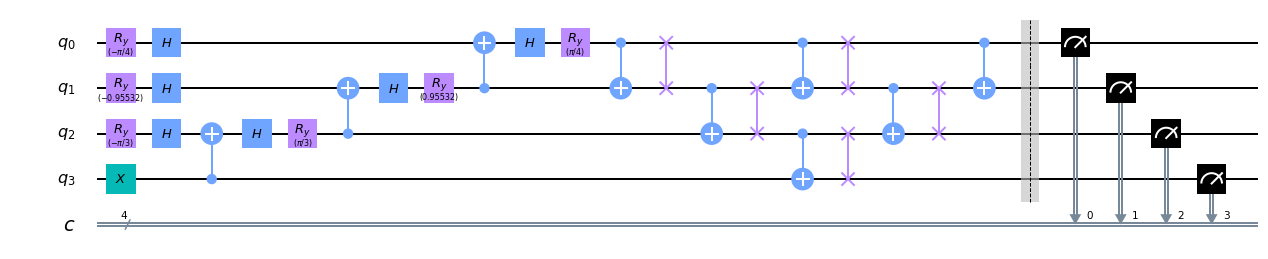

In [15]:
n_id = 0  # mainstream option: no delay time
             # modify for n_id > 0 (integer) for testing quantum state coherence evolution 

if n_id > 0:
    Delay_time = QuantumCircuit(4, 4)
    Delay_time.barrier();
    for i in range(n_id):
        for j in range(4):
            Delay_time.iden(j)
            
Measure = QuantumCircuit(4, 4)
Measure.barrier()
for j in range(4):
    Measure.measure(j,j)

if n_id > 0:
    Q_state_final = Q_state + Delay_time + Measure
elif n_id == 0:
    Q_state_final = Q_state + Measure
    
Q_state_final.draw(output='mpl')

## Get the optimized version of the circuit

You will now use the transpiler to get an optimized version of the final circuit.

An optimization level of 1 and the predefined initial layout are both specified in the call to the transpiler, insuring that the same circuit is run from experiment to experiment.

Pay attention to the depth and the gate repartition and check the layout (graph numbers refer to the *virtual* qubits). 

backend: ibmqx2  initial_layout: [4, 3, 2, 0, 1]
depth =  17
gates =  OrderedDict([('cx', 14), ('u3', 7), ('measure', 4), ('barrier', 1)])


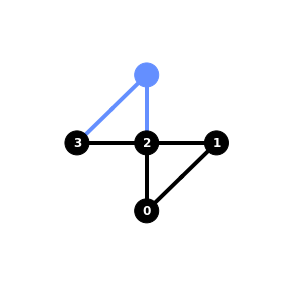

In [16]:
print("backend:", backend, " initial_layout:", Q_list)
Q_state_opt = transpile(Q_state_final, backend=backend, seed_transpiler=1, optimization_level=1, initial_layout=Q_list)
print('depth = ', Q_state_opt.depth())
print('gates = ', Q_state_opt.count_ops())
plot_circuit_layout(Q_state_opt, backend)

## Have a look at the optimized circuit before verification

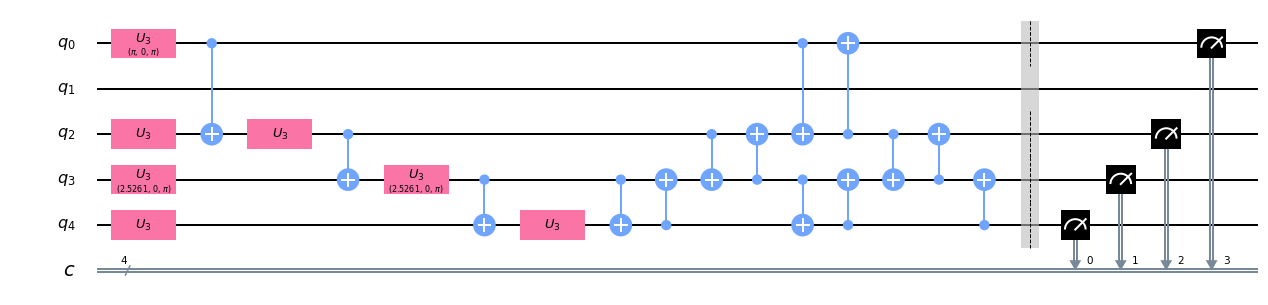

In [17]:
Q_state_opt_basis =  Q_state_opt.decompose()
Q_state_opt_basis.draw(output='mpl')

## Verify the circuit on a noise-free simulator

It's always a good precaution.

Expected result set: ('0001', '0010', '0100', '1000'), each with a probability around ¼

{'0001': 2061, '1000': 2009, '0100': 2041, '0010': 2081}


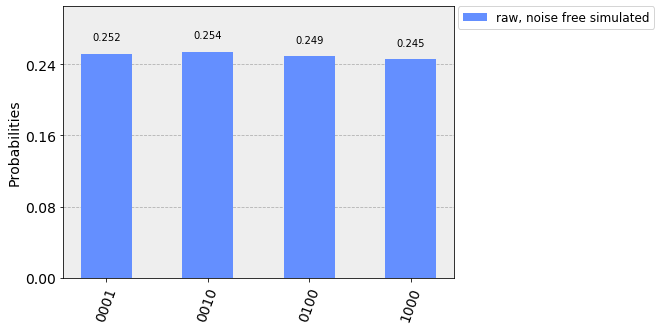

In [41]:
# Determine the simulator for circuit verification
simulator = Aer.get_backend('qasm_simulator')  
s_sim = 8192   
# Proceed to the verification
job = execute([Q_state_opt], backend=simulator, shots=s_sim)
results_sim = job.result()
raw_counts_sim = results_sim.get_counts()
print(raw_counts_sim)
plot_histogram(raw_counts_sim, legend=['raw, noise free simulated'])

## Obtain the training raw counts

In [19]:
nb_shots = 8192 # set here the number of shots for the training phase

In [20]:
# execute the circuit
job = execute([Q_state_opt], backend=backend, shots=nb_shots)
print(job.job_id())
job_monitor(job)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("DMY: ",time_exp)
results = job.result()

5de7f6e5fca0610011fef787
Job Status: job has successfully run
DMY:  04/12/2019 19:12:59


In [21]:
# Before obtaining and treating measurement data,
# make sure that the generated dictionaries will end with a complete set of keys

total_state_labels_list = ['0000','0001','0010','0011','0100', '0101', '0110', '0111',
                   '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
void_counts = dict(zip(total_state_labels_list, np.zeros(16, dtype=int)))

raw_counts = copy.deepcopy(void_counts)
raw_counts_test = copy.deepcopy(void_counts)
m_counts = copy.deepcopy(void_counts)
mct = copy.deepcopy(void_counts)

In [22]:
# Results without mitigation
raw_counts.update(results.get_counts())
print(raw_counts)

{'0000': 534, '0001': 1115, '0010': 1413, '0011': 195, '0100': 1667, '0101': 113, '0110': 232, '0111': 211, '1000': 1681, '1001': 120, '1010': 212, '1011': 170, '1100': 117, '1101': 181, '1110': 196, '1111': 35}


## Obtain the test raw counts 
 

In [23]:
nb_shots_test = 8192 # set here the number of shots for the testing phase

In [25]:
# run the circuit

time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("DMY: ",time_exp) 
job = execute([Q_state_opt], backend=backend, shots=nb_shots_test)
print(job.job_id())
job_monitor(job)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("DMY: ",time_exp)   
results_test = job.result()  

DMY:  04/12/2019 22:11:34
5de8210b5f8425001269eb80
Job Status: job has successfully run
DMY:  04/12/2019 22:12:36


In [26]:
# Test results without mitigation
raw_counts_test.update(results_test.get_counts())
print(raw_counts_test)

{'0000': 439, '0001': 1369, '0010': 1552, '0011': 158, '0100': 1846, '0101': 71, '0110': 197, '0111': 155, '1000': 1766, '1001': 68, '1010': 159, '1011': 126, '1100': 66, '1101': 70, '1110': 130, '1111': 20}


## ("Rerun without mitigation" point)

After completing QCMR, here is to restart (Cell - Run All Below) after setting the boolean variable "mitigation" to False for a rerun without prior mitigation.

## Look at the training results 

In [50]:
# (with remediation to the plot_histogram not displaying issue of Qiskit)
if mitigation:
    mitigated_results = meas_filter.apply(results, method = 'least_squares')
    m_counts.update(mitigated_results.get_counts(0))
    legend2 = "mitigated (training)"
    color2 = "m"
else:
    m_counts = raw_counts.copy()
    legend2 = "(no mitigation)"
    color2 = "c"
    
print(m_counts)

{'0000': 310.3575051800128, '0001': 1225.8139460878513, '0010': 1503.140075279526, '0011': 165.80014785535397, '0100': 1770.5950940750465, '0101': 59.15653234105788, '0110': 194.5589756653067, '0111': 230.83489021691454, '1000': 1795.4802190329485, '1001': 64.48800092324575, '1010': 179.35882355329161, '1011': 187.81753183885002, '1100': 69.37622189926466, '1101': 198.8644187804748, '1110': 209.37467249422917, '1111': 26.98294477662615}


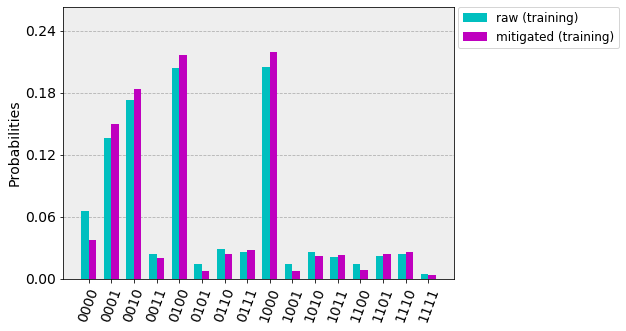

In [51]:
plot_histogram([raw_counts, m_counts], legend=['raw (training)', legend2],bar_labels=False, color=("c",color2))

## Reassignment procedure

Now you will reassign the probabilities observed for the illegal result set to items of the legal set.
 
There are $4^{12}$ possible combinations for the reassignment. It is now time to choose the metric and the optimization method.

### Choose the metric
To quantify the similarity between the observed distribution for each combination and the ideal distribution, the metrics at your disposal are for instance the squared Euclidean distance $SED$,
the Hellinger distance or the Bhattacharyya distance. These metrics are directly related to each other. $SED$ is chosen here since it involves fewer calculations in the program loops. 

$$SED\ =\ \sum_{i=1}^{4}{\ \left(\ p_i\ -\ q_i\right)^2}$$

### Optimization method
 
Among this huge number of combinations, you will need to find the best solution. A Bayesian multi-armed bandit optimization method was tested using GPyopt and was quite slow while easily getting stuck at local minima. Attempts based on dynamic programming collided with the limited number of a nested loops allowed in python. Finally, simple brute force provides the solution in a reasonable time on a laptop with python programming only.

Ready for finding the best combination with the lower SED? This will take some time (a few minutes on most systems).
 
(Note that connecting your laptop to the ac adapter rather than staying on battery can sometimes reduce the runtime by more than half)

In [52]:
# find the best combination

Q_dist = np.array([0.25, 0.25, 0.25, 0.25]) # ideal distribution

add_counts = np.array([m_counts['0000'], m_counts["0011"], m_counts["0101"], m_counts["0110"],
                    m_counts["0111"], m_counts['1001'], m_counts["1010"], m_counts["1011"],
                    m_counts["1100"], m_counts['1101'], m_counts["1110"], m_counts["1111"]])/nb_shots

new_sums_start = np.array([m_counts["0001"],m_counts["0010"],
                           m_counts["0100"],m_counts["1000"]])/nb_shots

pmq_start = np.subtract(new_sums_start, Q_dist)

SED = 2 # set starting maximal value for squared euclidean distance.

print("Start combinations",time.strftime('%d/%m/%Y %H:%M:%S'))            
time_start = time.time()

for combi in itertools.product(range(4),repeat = 12):   #  cartesian product, equivalent to a nested for-loop 
    
    pmq = pmq_start.copy()
    for i,v in enumerate(combi):   
        pmq[v] += add_counts[i]
    
    SED_new = np.dot(pmq , pmq)
    
    if SED_new <= SED:
        SED = SED_new
        combi_test = combi

print("performed in ",round((time.time()-time_start)/60,3),"min")

Start combinations 04/12/2019 22:38:18
performed in  2.308 min


## A look at the training results after reassignment

In [53]:
print("SED (training):", "%.6E" % SED, "for selected combination:", combi_test, "mitigation:", mitigation)

new_sums_selected = new_sums_start.copy()   
for i,v in enumerate(combi_test):   
            new_sums_selected[v] += add_counts[i]

legal_state_labels_list = ['0001', '0010', '0100', '1000']
prob_dict1 = dict(zip(legal_state_labels_list, new_sums_selected))

print(prob_dict1)

SED (training): 3.940647E-08 for selected combination: (0, 1, 0, 0, 0, 3, 1, 3, 2, 1, 2, 0) mitigation: True
{'0001': 0.24996396414401484, '0010': 0.24989788396834062, '0100': 0.2501643052329761, '1000': 0.2499738466546685}


## Training phase synthesis 

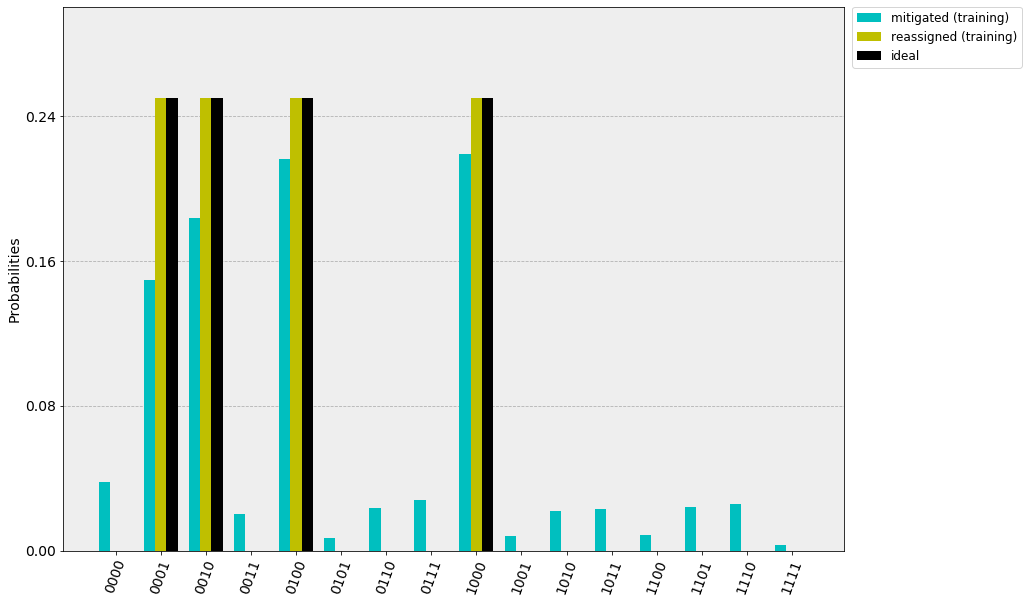

In [54]:
ideal_counts = {'0000':0.0, '0001':0.25, '0010':0.25, '0011':0.0,
                 '0100':0.25, '0101':0.0, '0110':0.0, '0111':0.0,
                 '1000':0.25 , '1001':0.0, '1010':0.0, '1011':0.0,
                 '1100':0.0, '1101':0.0, '1110':0.0, '1111':0.0}
illegal_state_labels_list = ['0000', '0011', '0101', '0110', '0111',
                   '1001', '1010', '1011', '1100', '1101', '1110', '1111']
prob_dict2 = dict(zip(illegal_state_labels_list, np.zeros(12)))
prob_dict= {**prob_dict1, **prob_dict2}
legend1 = "raw (training)"
color1 = "c"
if mitigation:
    legend1 = "mitigated (training)"
    color1 = "m"
plot_histogram([m_counts, prob_dict, ideal_counts],
                legend=[legend1, "reassigned (training)","ideal"],
                figsize=(14, 10),bar_labels=False, color=("c","y","k"))

## Create the mapping table

Let's create a dictionary relating the sixteen possible results to the four dice outcomes (1, 2, 3 and 4).

In [55]:
# create the dictionary

dice_values_list1 = [1,2,3,4]
dice_dict1 = dict(zip(legal_state_labels_list, dice_values_list1))
dice_values_list2 = []
for i,v in enumerate(combi_test):
    dice_values_list2.append(v+1)
illegal_state_labels_list = ['0000', '0011', '0101', '0110', '0111',
                   '1001', '1010', '1011', '1100', '1101', '1110', '1111']
dice_dict2 = dict(zip(illegal_state_labels_list, dice_values_list2))
dice_dict= {**dice_dict1, **dice_dict2}

## Throw the dice

You have now completed the making of the quantum dice. 

Suppose you make a one shot experiment and you get a four bit result in the classical registers.

Run the following cell to see to which dice outcome it corresponds.

In [56]:
# throw the dice
key_side = "1101" # indicate here your result
print("dice value is",  dice_dict[key_side], "for result", key_side)

dice value is 2 for result 1101


## Look now at the test results

In [57]:
# (with remediation to the plot_histogram not displaing issue of Qiskit)
if mitigation:
    mit_results_test = meas_filter.apply(results_test, method = 'least_squares')
    mct.update(mit_results_test.get_counts(0))
    legend2 = "mitigated (test)"
    color2 = "m"
else:
    mct = raw_counts_test.copy()
    legend2 = "(no mitigation)"
    color2 = "c"
    
print(raw_counts_test)
if mitigation:
    print(mct)

{'0000': 439, '0001': 1369, '0010': 1552, '0011': 158, '0100': 1846, '0101': 71, '0110': 197, '0111': 155, '1000': 1766, '1001': 68, '1010': 159, '1011': 126, '1100': 66, '1101': 70, '1110': 130, '1111': 20}
{'0000': 172.34176366542596, '0001': 1519.3631276140804, '0010': 1661.757418785648, '0011': 119.78759816083154, '0100': 1969.821976889025, '0101': 11.077781026245347, '0110': 160.17348251504873, '0111': 165.86237843739218, '1000': 1896.5735321430343, '1001': 4.475774388984414, '1010': 123.48307981201799, '1011': 140.03980665185696, '1100': 23.800628533233063, '1101': 71.76216878813429, '1110': 137.84174377441747, '1111': 13.837738814625393}


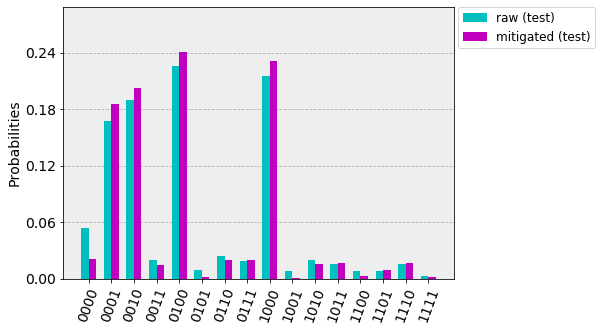

In [58]:
plot_histogram([raw_counts_test, mct], legend=['raw (test)', legend2],bar_labels=False, color=("c",color2))

##  Reassignment procedure for the test results

You will proceed to the reassignment by applying the best combination determined at training. 

In [59]:
add_counts_test =  np.array([mct['0000'], mct["0011"], mct["0101"], mct["0110"],
                  mct["0111"], mct['1001'], mct["1010"], mct["1011"],
                  mct["1100"], mct['1101'], mct["1110"], mct["1111"]])/nb_shots_test
                
new_sums_test = np.array([mct["0001"], mct["0010"], mct["0100"], mct["1000"]])/nb_shots_test   
    
for i,v in enumerate(combi_test):   
    new_sums_test[v] += add_counts_test[i]

pmq_test = np.subtract(new_sums_test, Q_dist) 
SED_test = np.dot(pmq_test , pmq_test)

print("SED (test):", "%.6E" % SED_test , "for selected combination:", combi_test, "mitigation:", mitigation)

prob_dict1_test = dict(zip(legal_state_labels_list, new_sums_test))
print(prob_dict1_test)

SED (test): 1.805043E-04 for selected combination: (0, 1, 0, 0, 0, 3, 1, 3, 2, 1, 2, 0) mitigation: True
{'0001': 0.24934768946201394, '0010': 0.24130740546223534, '0100': 0.26018851918904734, '1000': 0.24915638588670358}


## Test phase synthesis

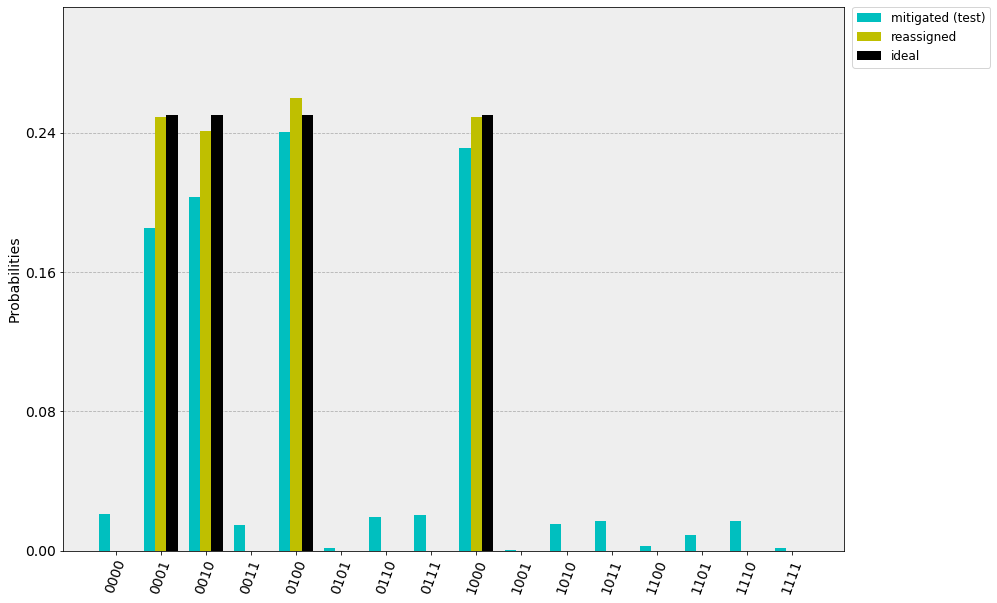

In [60]:
prob_dict_test= {**prob_dict1_test, **prob_dict2}
legend1 = "raw (test)"
color1 = "c"
if mitigation:
    legend1 = "mitigated (test)"
    color1 = "m"
plot_histogram([mct, prob_dict_test, ideal_counts],
                legend=[legend1, "reassigned","ideal"],
                figsize=(14, 10),bar_labels=False, color=("c","y","k"))

##  Experimentally assess the evolution of  the four-qubit entangled state  coherence

To vary the delay time, you will now insert $n_{id}$ identity gates between the circuit creating $\mid Q \rangle$ and the measurement.

If fact, you will not observe directly the coherence decay, but infer its evolution from the effect of an increasing $n_{id}$  on $P_{obs}$ and $SED$ .

Now the reassignment of the mitigated results will be made using the best combination determined from a training phase concerning the new deeper circuit.

A different training phase for each $n_{id}$ value is justified by the fact that $n_{id}$ is known at the moment of the reassignment procedure. 

From a series of experiments, it is therefore possible to create a table of best combinations vs. $n_{id}$ .  

Figures 1a and 1b show the test results of a such a series on ibmq_london. This device was chosen on the sole criterion of a reduced queuing time on experimentation day (November 28th, 2019). The number of shots was always 8192 for training and test. 

For reassignment alone, the $P_{obs}$ is skewed toward '0100' from a $n_{id}$ threshold of 32 with corresponding circuit depth of 49 gates. For QCMR, the same skewing is observed only from a $n_{id}$ threshold of 256 and depth of 273 gates.

<img src="Reass_alone.png" width="800" />

$$ Figure \ 1a $$

<img src="QCMR.png" width="800" />

$$ Figure \ 1b $$ 

The superiority of QCMR is confirmed by looking (Figure 2) at the $SED$ evolution with $n_{id}$. With reassignment alone, $SED$ remains acceptable up to a $n_{id}$ threshold of 32 . With full QMR, this threshold increases to 128.

<img src="SED_QCMR.png" width="800" />

$$ Figure \ 2 $$

Depending on the device specific identity gate operation time, QMR allows thus preservation of coherence after a creation plus delay time of the order of several $\mu s$. For instance, for these experiments on ibmq_london, one can estimate, using the data of "backend.properties()", a state creation time of about 5 $\mu s$ and a delay time of about 4.5 $\mu s$ at $n_{id} = 256$
, for a total of about 9.5 $\mu$ without appreciable deterioration of the four-qubit entangled state coherence.


### Remarks:

##### _Black box conundrum_

Reassignment works in QCMR as a black box. It comes on top of a mitigation technique ([Kandala et al](https://www.nature.com/articles/s41586-019-1040-7)) more rigorously justified. For QCMR, it remains unknown what levels and properties of the noise explain the effectiveness of the trick of the best combination. [Ozaeta & McMahon](https://arxiv.org/abs/1712.07080v2) already concluded that their own data on multi-qubit quantum state decoherence were "consistent with a model in which the dominant noise affecting the system is uncorrelated across qubits". When preparing the present tutorial, it was observed that the performance of the QCMR protocol was actually affected when attempting to constrain this blackbox to a search space of combinations with some degree of parenthood between illegal results and they reassigned legal results (for example excluding to reassign '0011' to '1000' and to '0100', and so on). These observations can justify the use of QCMR despite a "black box conundrum".

##### _Deeper circuits are not a problem_

QCMR works better sometimes if a weak link is eliminated by modifying the qubit layout even if this leads to a deeper circuit. On the Vigo and Burlington devices for instance, the a priori more fitted shallow circuits, with depth 17, gave unsatisfactory final distributions. These circuits included physical qubit 4, whose U2 error rate was relatively high. Circuits of depth 52 after substitution were then tried and gave satisfactory final distributions with low $SED$.

##### _Fields of application_

This kind of protocol can be considered in the making of randomizers, in the stabilization of qRAM and in the transmission of multi-qubit entangled quantum states in some protocols of cryptography or delegated quantum computaion. This list is not exhaustive. QCMR is not limited to muti-qubit W-states: other entangled states associated with different multinomial distributions for the measurement results can be considered.

### Addenda

#####  Want to try a QMR with delay time using the same training and test results?

If you wish, you may now rerun the cells from "Setting the delay time" by introducing a positive integer value for $n_{id}$. 

##### Want to try a reassignment process without prior mitigation?

In this case, execute the next cell and return to the cell "("Rerun without mitigation" point)" here above.

In [61]:
mitigation = False # run this cell if mitigation is wanted, then back to "("Rerun without mitigation" point)"

In [62]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright